In [346]:
import json
import logomaker
from collections import Counter
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

## Figure 5: genotype of circulating human virus impacts available HA1 adaptive mutations

In [74]:
def get_tip_freqs(virus, segment):
    """
    Read in the tip frequency json file
    """
    if segment.lower()=='ha':
        num_tips = 10000
    else:
        num_tips = 4000
    freqs_path= f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_{segment}_tip-frequencies.json'
    
    with open(freqs_path, 'r') as f:
        tip_freqs = json.load(f)
        
    # only return non-egg seqs
    tip_freqs = {k:v for k,v in tip_freqs.items() if '-egg' not in k}


    return tip_freqs
    

In [145]:
def get_nonegg_proportion(virus, segment):
    """
    get the proportion egg/nonegg in each pivot
    """
    if segment.lower()=='ha':
        num_tips = 10000
    else:
        num_tips = 4000
    freqs_path= f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_{segment}_tip-frequencies.json'
    
    with open(freqs_path, 'r') as f:
        tip_freqs = json.load(f)
        
    pivots = tip_freqs['pivots']
    
    count_egg_by_pivot = np.zeros(len(pivots))
    count_nonegg_by_pivot = np.zeros(len(pivots))
        
    for k,v in tip_freqs.items():
        if k!= 'generated_by' and k!='pivots':
            if '-egg' in k:
                count_egg_by_pivot += np.array(v['frequencies'])
            else:
                count_nonegg_by_pivot += np.array(v['frequencies'])
                
    nonegg_proportion = count_nonegg_by_pivot/(count_nonegg_by_pivot+count_egg_by_pivot)


    return nonegg_proportion

In [189]:
def get_tip_genotype(virus, segment, gene, site):
    """
    Get the AA genotype at this site. Return separate dictionaries for non-egg tips, and egg tips
    """
    if segment.lower()=='ha':
        num_tips = 10000
    else:
        num_tips = 4000
        
    root_path = f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_{segment}_root-sequence.json'
    
    with open(root_path, 'r') as f:
        root_json = json.load(f)
    # get the root AA at this site
    root_aa_site = root_json[gene][site-1]
    
    #read in the tree
    tree_path= f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_{segment}.json'
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    # apply any muts to root
    root_muts = tree.root.branch_attrs['mutations'].get('HA1', '')
    for m in root_muts:
        if int(m[1:-1]) == site:
            root_aa_site = m[-1]
    
    # record all muts at this site by what branch they occur on
    muts_at_site = {}
    
    for node in tree.find_clades():
        ha1_muts = node.branch_attrs['mutations'].get('HA1', '')
        ha1_mut_sites = [int(x[1:-1]) for x in ha1_muts]
        if site in ha1_mut_sites:
            for y in ha1_muts:
                if int(y[1:-1])==site:
                    muts_at_site[node.name] = y
                    
    # record the AA genotype at this site for each tip
    # by tracing AA from root to tip
    tip_to_aa = {}
    tip_to_aa_egg = {}
    for node in tree.find_clades(terminal=True):
        # get path to root
        path_to_root = [x.name for x in tree.get_path(node)]
        muts_on_path = [muts_at_site.get(n, '') for n in path_to_root]
        # get most recent mut
        last_mut = next((x for x in reversed(muts_on_path) if x != ''), '')
        if last_mut=='':
            site_aa = root_aa_site
        else:
            site_aa = last_mut[-1]
            
        # for only non-egg seqs
        if node.node_attrs['passage_category']['value'] != 'egg':
            tip_to_aa[node.name] = site_aa
            
        # for only egg seqs
        if node.node_attrs['passage_category']['value'] == 'egg':
            tip_to_aa_egg[node.name] = site_aa
            
    return tip_to_aa, tip_to_aa_egg

In [195]:
def get_egg_muts_per_pivot(virus, segment, gene, egg_muts):
    """
    Return the strains with a the given egg mut(s) in each pivot
    """
    
    # get muts for each strain
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
        
    muts_by_strain = {}
        
    for strain, muts in egg_mut_info.items():
        muts_by_strain[strain] = muts.get(gene, [])
    
    # read in freqs file to get pivots
    if segment.lower()=='ha':
        num_tips = 10000
    else:
        num_tips = 4000
    freqs_path= f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_{segment}_tip-frequencies.json'
    
    with open(freqs_path, 'r') as f:
        tip_freqs = json.load(f)
        
    pivots = tip_freqs['pivots']
    
    # now read in tree to find dates of egg-passaged strains and assign them to a pivot
    tree_path = f'../nextstrain_builds/egg-enriched/{num_tips}tips/auspice/{virus}_30y_egg_{segment}.json'
    
    with open(tree_path, 'r') as f:
        tree_json = json.load(f)
        
    #put tree in Bio.phylo format
    tree = json_to_tree(tree_json)
    
    # get date for each egg strain and assing it to a pivot
    # put it in the last pivot it is greater than
    # ex: if date is 20.19, and pivots are 20.1, 20.2, then assign it to 20.1
    # need to check if that is right
    egg_strains_per_pivot = [[] for x in pivots]
    for node in tree.find_clades(terminal=True):
        # looking for only egg seqs
        if node.node_attrs['passage_category']['value'] == 'egg':
            num_date = node.node_attrs['num_date']['value']
            # get pivot
            node_pivot = max([x for x in pivots if x < num_date])
            node_pivot_index = pivots.index(node_pivot)
            egg_strains_per_pivot[node_pivot_index].append(node.name)
            
    # now find how many strains with the given mut(s) 
    muts_per_pivot = {}
    for m in egg_muts:
        this_mut_all_pivots = []
        # iterate through pivots
        for i, pivot_strains in enumerate(egg_strains_per_pivot):
            egg_strain_w_mut_this_pivot = []
            # iterate through strains in pivot
            for s in pivot_strains:
                # get muts
                if m in muts_by_strain[s]:
                    egg_strain_w_mut_this_pivot.append(s)
            this_mut_all_pivots.append(egg_strain_w_mut_this_pivot)
            
            
        muts_per_pivot[m] = this_mut_all_pivots
    

    return muts_per_pivot

In [332]:
# precompute all non egg aa frequencies at relevant sites before plotting
precomputed_tip_freqs = {'h1n1pdm':{}, 'h3n2':{}}
precomputed_tips_to_aa = {'h1n1pdm':{}, 'h3n2':{}}
precomputed_tips_to_aa_egg = {'h1n1pdm':{}, 'h3n2':{}}

H1_sites = [130, 183]
for s in H1_sites:
    tip_freqs = get_tip_freqs('h1n1pdm', 'ha')
    tip_to_aa, tip_to_aa_egg = get_tip_genotype('h1n1pdm', 'ha', 'HA1', s)
    precomputed_tip_freqs['h1n1pdm'][s] = tip_freqs
    precomputed_tips_to_aa['h1n1pdm'][s] = tip_to_aa
    precomputed_tips_to_aa_egg['h1n1pdm'][s] = tip_to_aa_egg
    
H3_sites= [156, 186, 189, 193, 225, 226]
for s in H3_sites:
    tip_freqs = get_tip_freqs('h3n2', 'ha')
    tip_to_aa, tip_to_aa_egg = get_tip_genotype('h3n2', 'ha', 'HA1', s)
    precomputed_tip_freqs['h3n2'][s] = tip_freqs
    precomputed_tips_to_aa['h3n2'][s] = tip_to_aa
    precomputed_tips_to_aa_egg['h3n2'][s] = tip_to_aa_egg
    

In [168]:
# map each aa to a different color
all_amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

color_palette = sns.color_palette("tab20", 20)

aa_cmap = {aa: color for aa, color in zip(all_amino_acids, color_palette)}

In [226]:
ha_residue_cmap = {'h3n2': {138: '#fb8500', 
                            156: '#006e5e', 160: '#00c88a', 
                            183: "#e9bfe1", 186: '#653790', 190: '#9C3587', 194: '#da93cc', 
                            219: '#0077b6', 225: '#00b4d8', 226: '#90e0ef', 
                            203: '#FD3855', 246: '#fe96ac'}, 
                   'h1n1pdm': {127: '#fb8500', 187: "#e9bfe1", 191: '#9C3587', 
                               222: '#0077b6', 223: '#00b4d8'}, 
                   'vic': {196: "#e9bfe1", 198: '#9C3587'}, 
                   'yam': {141: '#FD3855', 195: "#e9bfe1", 197: '#9C3587'}
                  }

In [286]:
human_aa_cmap = {'h3n2': ['#6C3BAA', '#c8b1e4', '#9e77d0', '#e7ddf3', '#7f4cc1', '#502c7e', '#f1ecf8', '#221336', '#b394da'], 
                 'h1n1pdm': ['#45b6fe', '#a7dcff', '#017dcc','#e1f3ff', '#0a9ffe', '#015992', '#002944'], 
                 'vic': ['#FF4500'], 'yam': ['#fbba0a']}

In [393]:
random_colors = {'h3n2':['#6C3BAA', '#fb8500', '#006e5e', '00b4d8', '#fe96ac', '#00c88a', 
                      "#e9bfe1", '#653790', '#9C3587', '#da93cc', '#0077b6','#90e0ef', '#FD3855'], 
                 'h1n1pdm':['#45b6fe', '#fb8500', '#006e5e', '00b4d8', '#fe96ac', '#00c88a', 
                      "#e9bfe1", '#653790', '#9C3587', '#da93cc', '#0077b6','#90e0ef', '#FD3855']}

In [333]:
grayscale_colors = ['#808080', '#d8d8d8', '#595959', '#bbbbbb', '#ececec', 
                    '#323232', '#949494', '#1e1e1e', 
                    '#f6f6f6', '#f6f6f6', '#f6f6f6', '#f6f6f6', '#f6f6f6']

In [364]:
virus_cmap = {'h3n2': ['#6C3BAA', '#a986d5'], 
              'h1n1pdm': ['#45b6fe', '#a2dafe'], 
              'vic': ['#FF4500', '#ffa27f'], 
              'yam': ['#fbba0a', '#ffa27f']}

In [394]:
def plot_site_aa_freqs(virus, segment, gene, site, egg_muts):
    """
    Plot the frequency of AA genotypes over time at this site in non-egg strains
    """
    
    if site in precomputed_tip_freqs[virus].keys():
        tip_freqs = precomputed_tip_freqs[virus][site]
        tip_to_aa = precomputed_tips_to_aa[virus][site]
        tip_to_aa_egg = precomputed_tips_to_aa_egg[virus][site]
    
    
    else:
        tip_freqs = get_tip_freqs(virus, segment)
        tip_to_aa, tip_to_aa_egg = get_tip_genotype(virus, segment, gene, site)
    
    # get dates for pivots
    time_pivots = np.array(tip_freqs['pivots'])
        
    # get proportion non egg in each pivot
    nonegg_proportion = get_nonegg_proportion(virus, segment)

    # convert this to aa frequencies over time
    aa_freqs = {}
    for t, f in tip_freqs.items():
        if t!='generated_by' and t!='pivots':
            aa = tip_to_aa[t]
            if aa in aa_freqs:
                # numpy array to add freqs at each pivot
                aa_freqs[aa] += np.array(f['frequencies'])
            else:
                aa_freqs[aa] = np.array(f['frequencies'])

    # Extract amino acid labels and array of frequencies
    aa_labels = list(aa_freqs.keys())
    # assign colors from cmap
#     colors = [grayscale_colors[i] for i in range(len(aa_labels))]
#     colors = [aa_cmap[a] for a in aa_labels]
    human_aa_to_color = {aa:random_colors[virus][i] for i,aa in enumerate(aa_labels)}
    colors = [random_colors[virus][i] for i in range(len(aa_labels))]
    # normalize to proportion of samples in pivot that are non-egg 
    frequency_data = np.array([aa_freqs[aa]*1/nonegg_proportion for aa in aa_labels])
    
    # now get egg muts per pivot
    muts_per_pivot = get_egg_muts_per_pivot(virus, segment, gene, egg_muts)
    
    # h1n1pdm has "unused" pivots because it was run with 30y res but seqs only start in 2009
    # need to truncate the arrays to just the relevant pivots
    if virus == 'h1n1pdm':
        truncate_at = next((i for i, value in enumerate(time_pivots) if value > 2009))
        frequency_data = np.array([x[truncate_at:] for x in frequency_data])
        time_pivots = np.array(time_pivots[truncate_at:])
        muts_per_pivot = {k:v[truncate_at:] for k,v in muts_per_pivot.items()}
        
    # at each pivot, get egg strains with the specified mutations
    # and find what genotype they are at the "site"
    # store this as a list of dictionaries with pivot (time point), "site" aa, and count
    egg_mut_info = {}
    for egg_mut, d in muts_per_pivot.items():
        # for each strain with mutation "egg_mut", find the genotype at 'site'
        site_genotype_per_pivot = [[tip_to_aa_egg[s] for s in x] for x in d]
        site_genotype_counts = []
        for i,p in enumerate(site_genotype_per_pivot):
            # get all unique genotypes in this pivot
            unique_aas = list(set(p))
            for u in unique_aas:
                site_genotype_counts.append({'time_point':time_pivots[i], 
                                             'aa': u, 'count': len([x for x in p if x==u])})
        egg_mut_info[egg_mut] = site_genotype_counts
        
        
    # counts for table
    
        
        
    #plot styling
    sns.set_style("white")
    plt.rcParams['figure.dpi']= 300
    plt.rcParams['font.family'] = 'Arial'


    # Create a stacked area plot
    fig, ax = plt.subplots(figsize=(10, 6))
    cumulative_data = np.cumsum(frequency_data, axis=0)
    base_data = np.vstack([np.zeros(frequency_data.shape[1]), cumulative_data[:-1]])

    stack = ax.stackplot(time_pivots, frequency_data, labels=aa_labels, alpha=0.5, colors=colors)
    
    # Overlay scatter points for mutations
    aa_to_idx = {aa: idx for idx, aa in enumerate(aa_labels)}
    i=0
    for m, d in egg_mut_info.items():
        # get color
        pos = int(m[:-1])
#         c = virus_cmap[virus][i]
        i+=1
#         c = ha_residue_cmap[virus][pos]
        for p in d:
            c = human_aa_to_color[p['aa']]
            # Find the closest time point in `time_pivots`
            time_idx = np.abs(time_pivots - p['time_point']).argmin()
            aa_idx = aa_to_idx[p['aa']]

            # Calculate the vertical position for the scatter points
            y_base = base_data[aa_idx, time_idx]
            y_top = cumulative_data[aa_idx, time_idx]

            # Scatter the mutation counts
            y_positions = np.linspace(y_base, y_top, p['count'] + 2)[1:-1]

            ax.scatter(np.full_like(y_positions, p['time_point']), y_positions, 
                       color=c, s=150, zorder=3)
            
            
    # label predominant human aas at "site"
    aas_to_label = []
    for i,aa in enumerate(aa_labels):
        # label those that exceed 0.3
        if np.any(aa_freqs[aa]>0.3):
            aas_to_label.append({'aa':aa, 'color':colors[i]})
            
    # make legened
    legend_handles = [Patch(color=x['color'], label=x['aa'], alpha=0.5) for x in aas_to_label]
    ax.legend(handles=legend_handles, title=f"{site}", fontsize=18,  bbox_to_anchor=(1.15, 0.8))
    

            
    # make y-axis invisible
    ax.yaxis.set_visible(False) 
    ax.spines['left'].set_color('white')
#     ax.set_ylabel(f'AA frequency at Residue {site}')
    

    sns.despine()



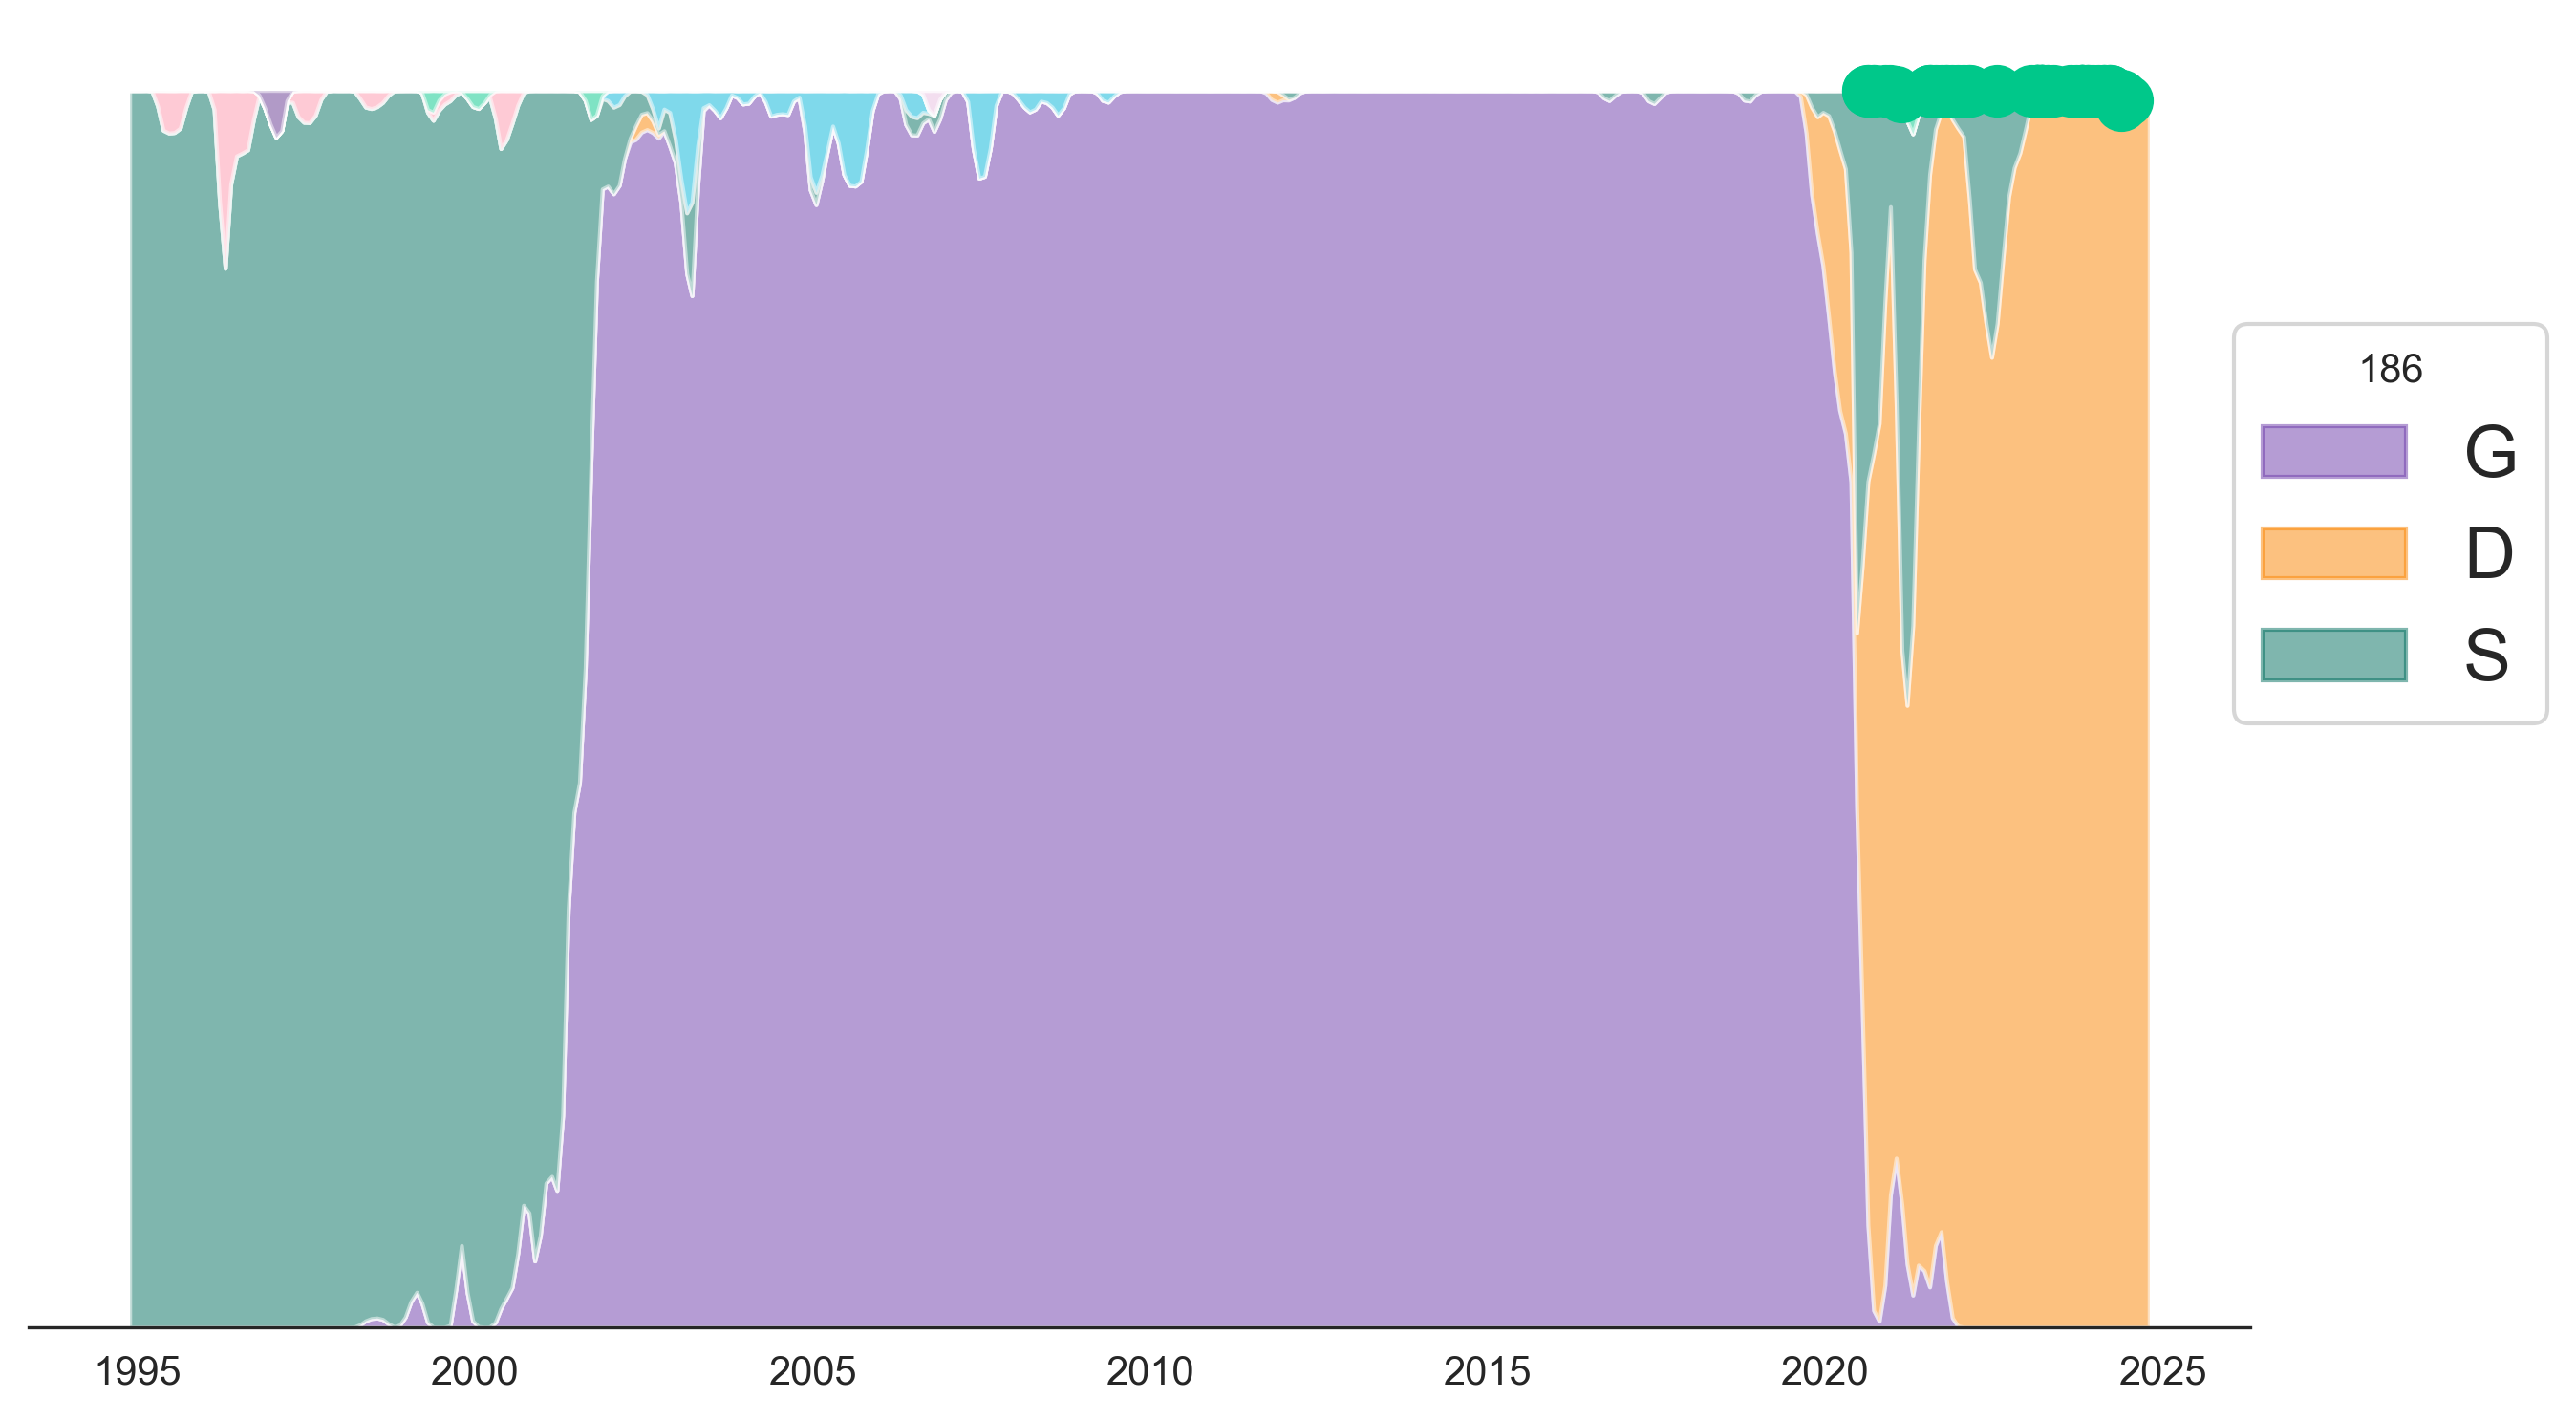

In [395]:
# need to alter code for if it's the same site
plot_site_aa_freqs('h3n2', 'ha', 'HA1', 186, ['186N'])

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

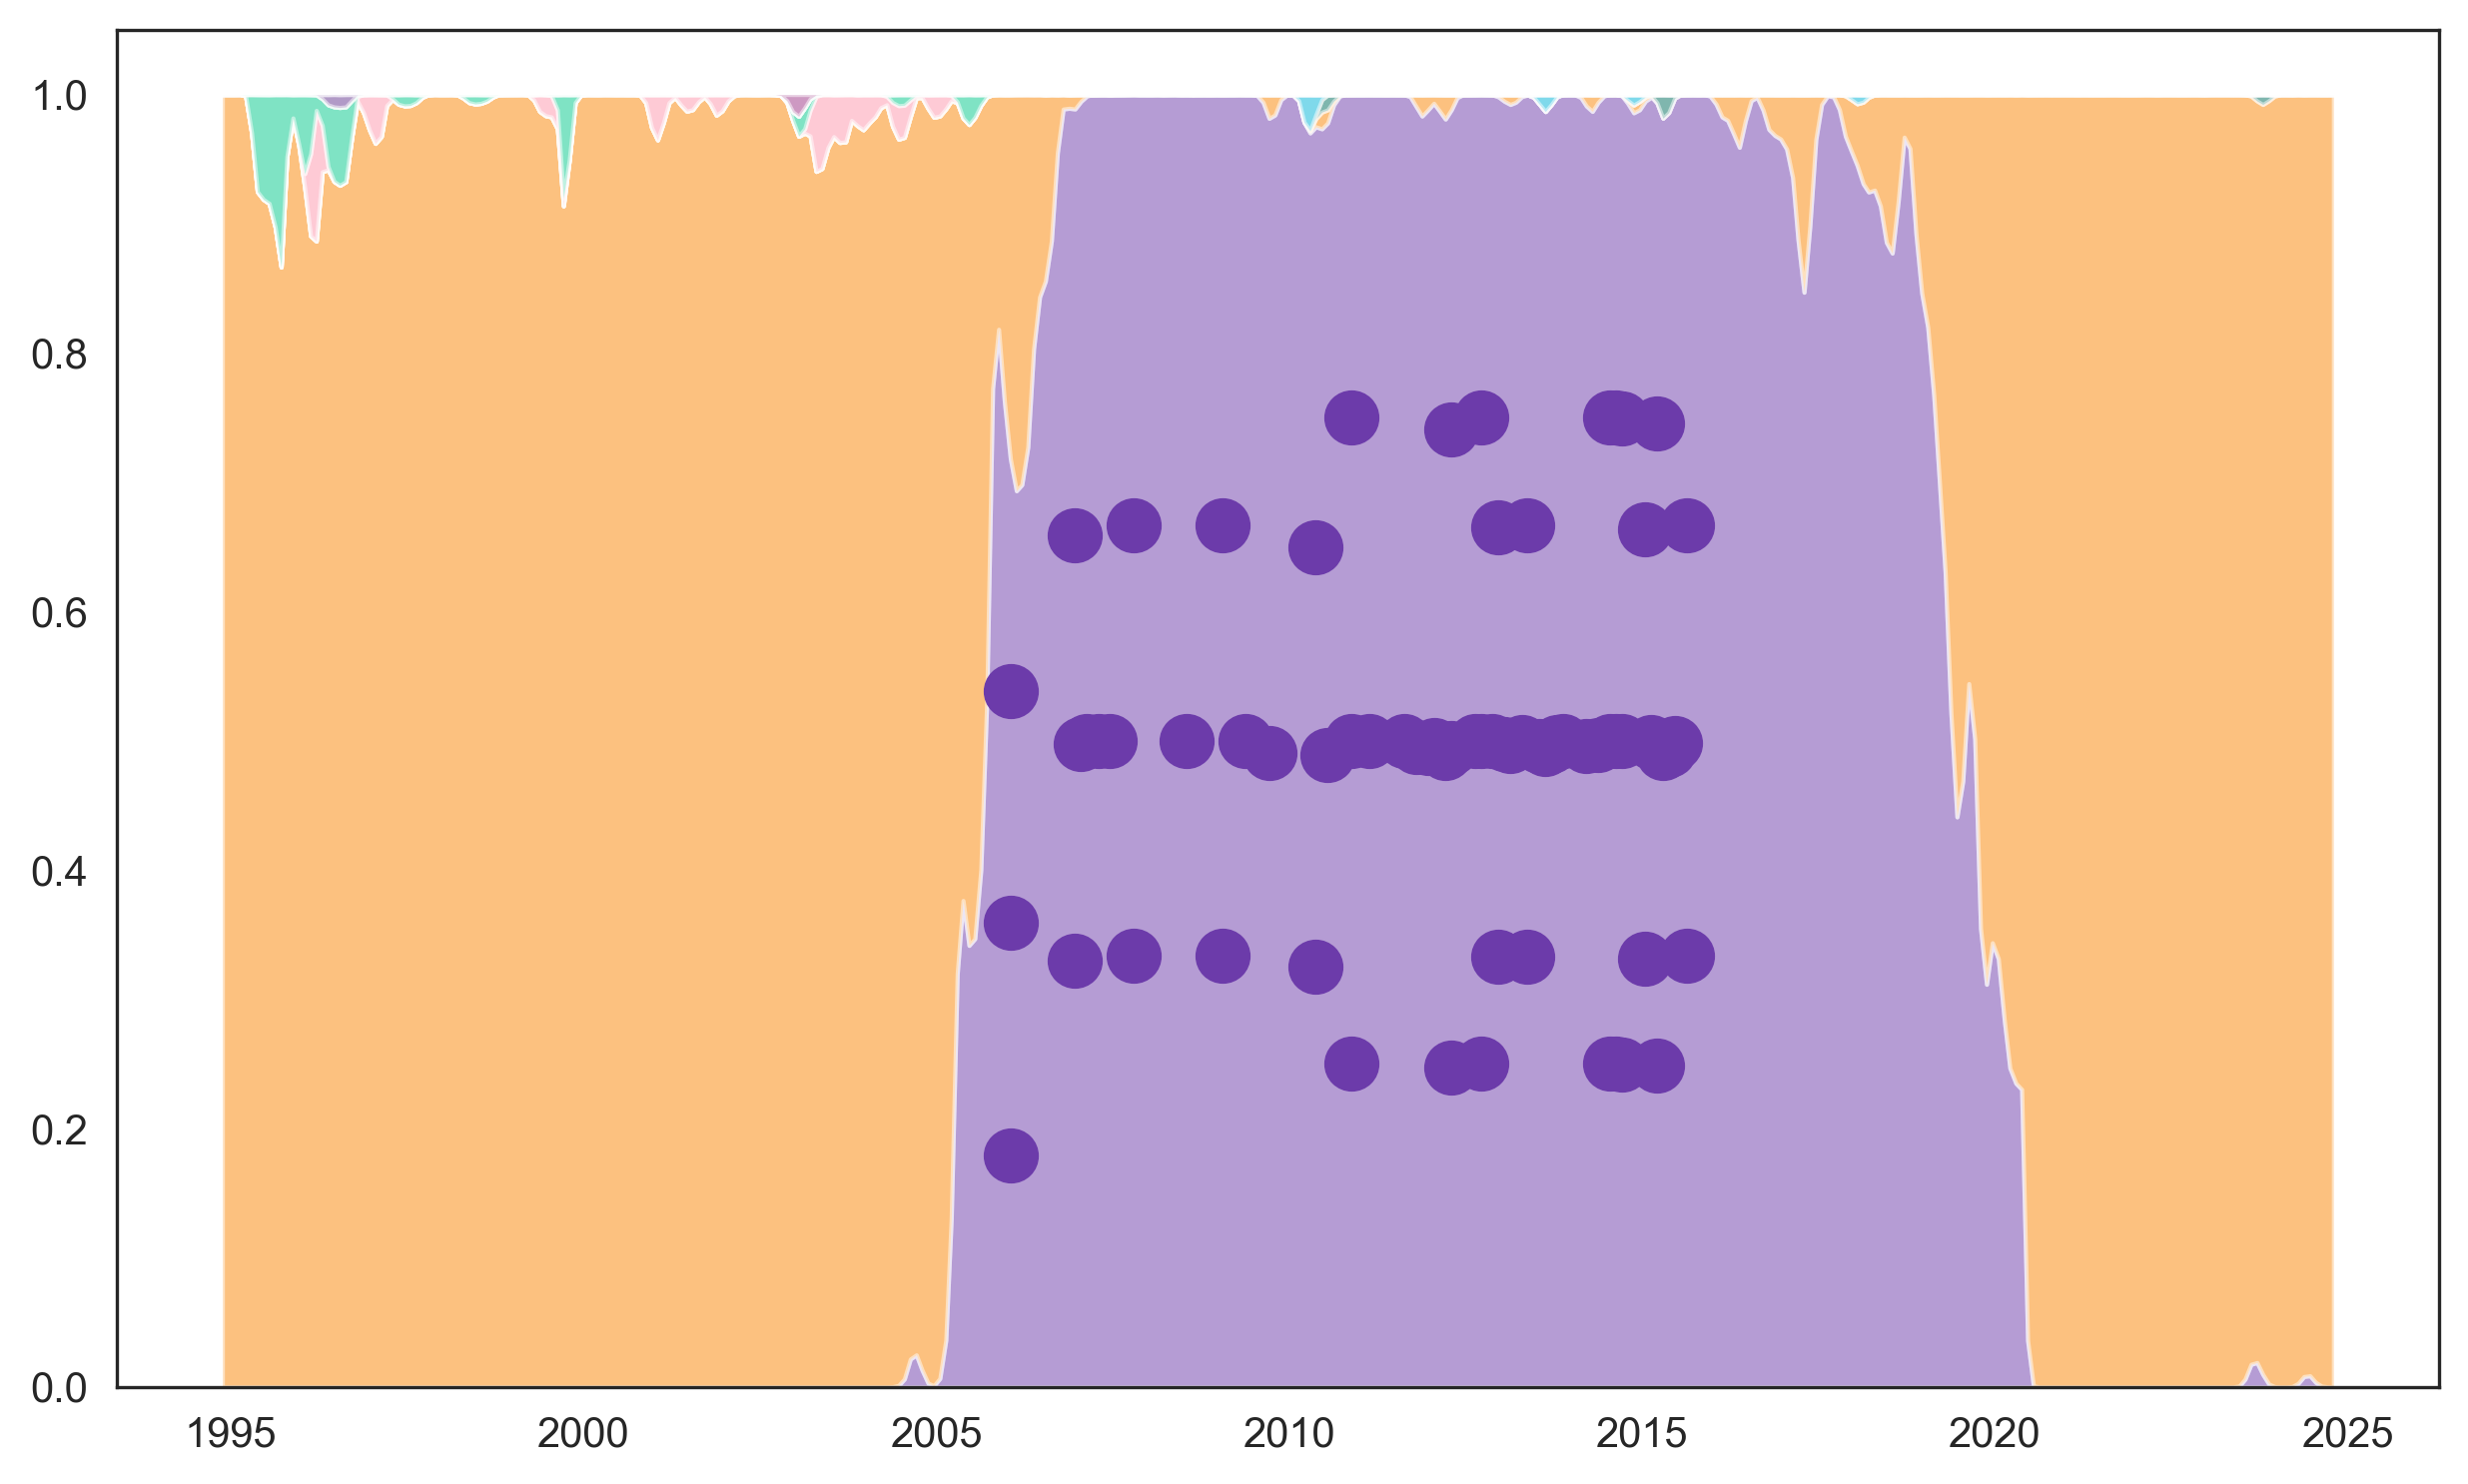

In [396]:
plot_site_aa_freqs('h3n2', 'ha', 'HA1', 193, ['194P'])

/var/folders/g_/6938g_6s199gxxswt2nf7w500000gn/T/ipykernel_13483/3478707030.py:26: RuntimeWarning: invalid value encountered in true_divide
  nonegg_proportion = count_nonegg_by_pivot/(count_nonegg_by_pivot+count_egg_by_pivot)


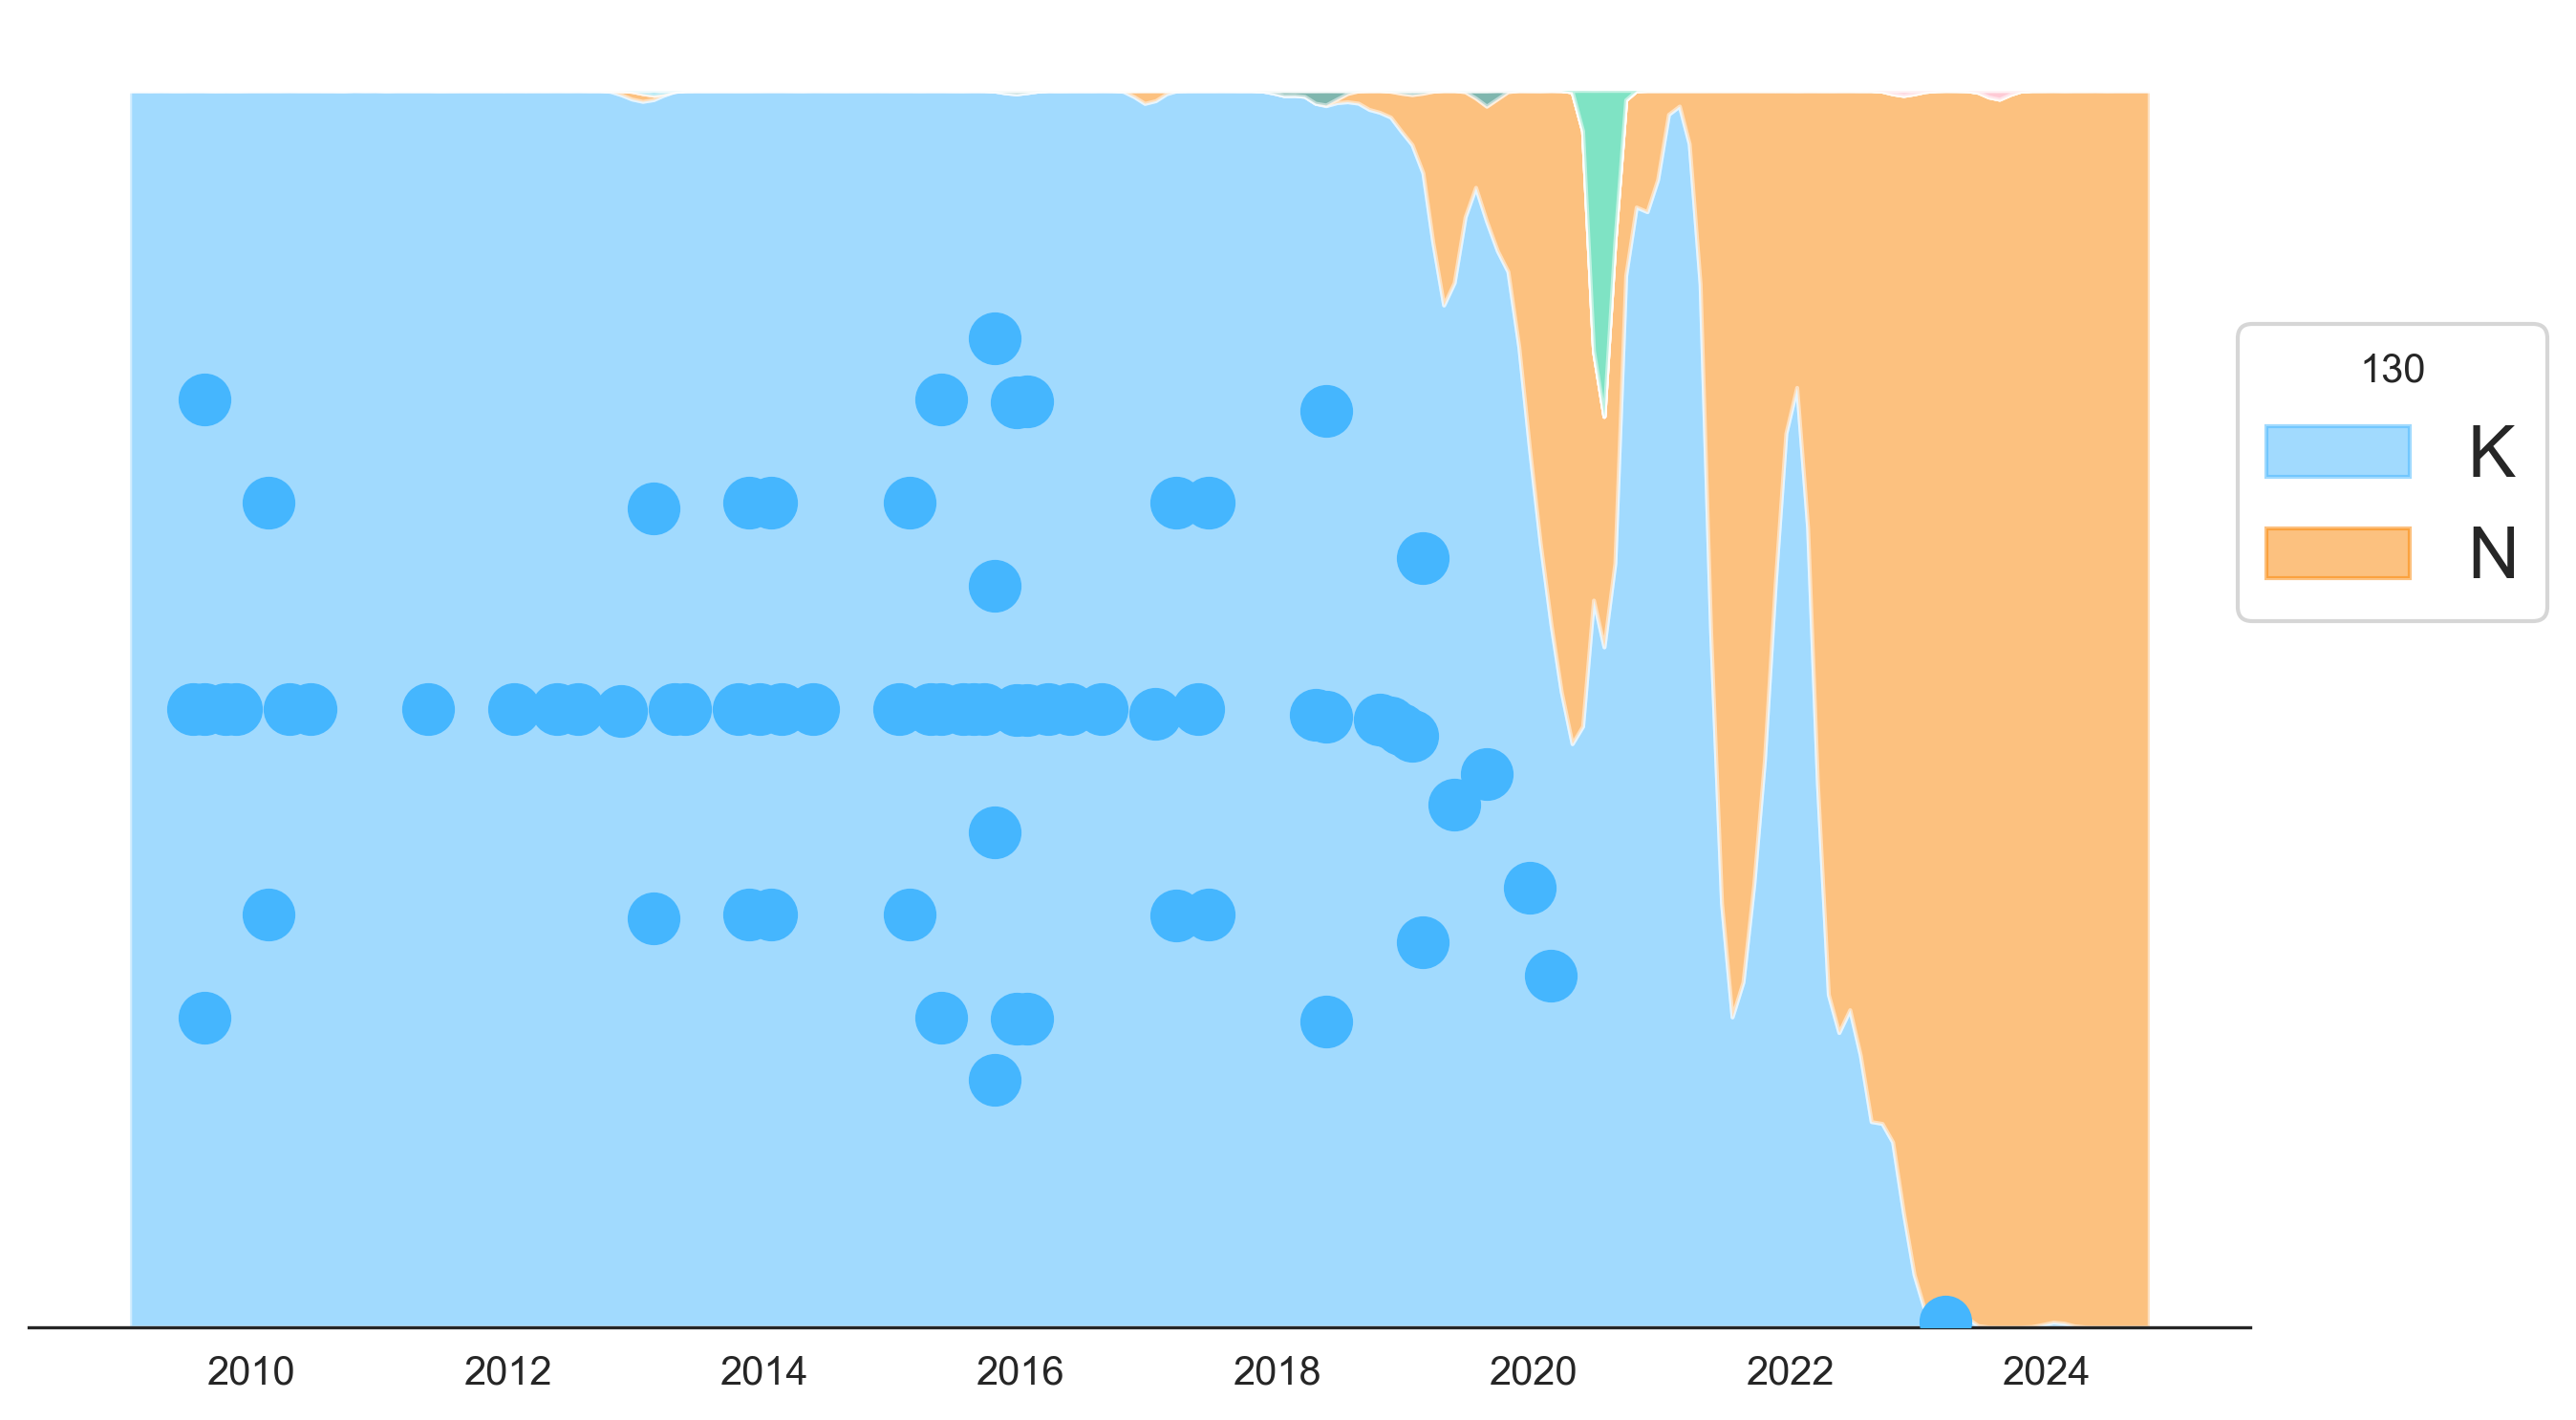

In [397]:
plot_site_aa_freqs('h1n1pdm', 'ha', 'HA1', 130, ['127E'])

/var/folders/g_/6938g_6s199gxxswt2nf7w500000gn/T/ipykernel_13483/3478707030.py:26: RuntimeWarning: invalid value encountered in true_divide
  nonegg_proportion = count_nonegg_by_pivot/(count_nonegg_by_pivot+count_egg_by_pivot)


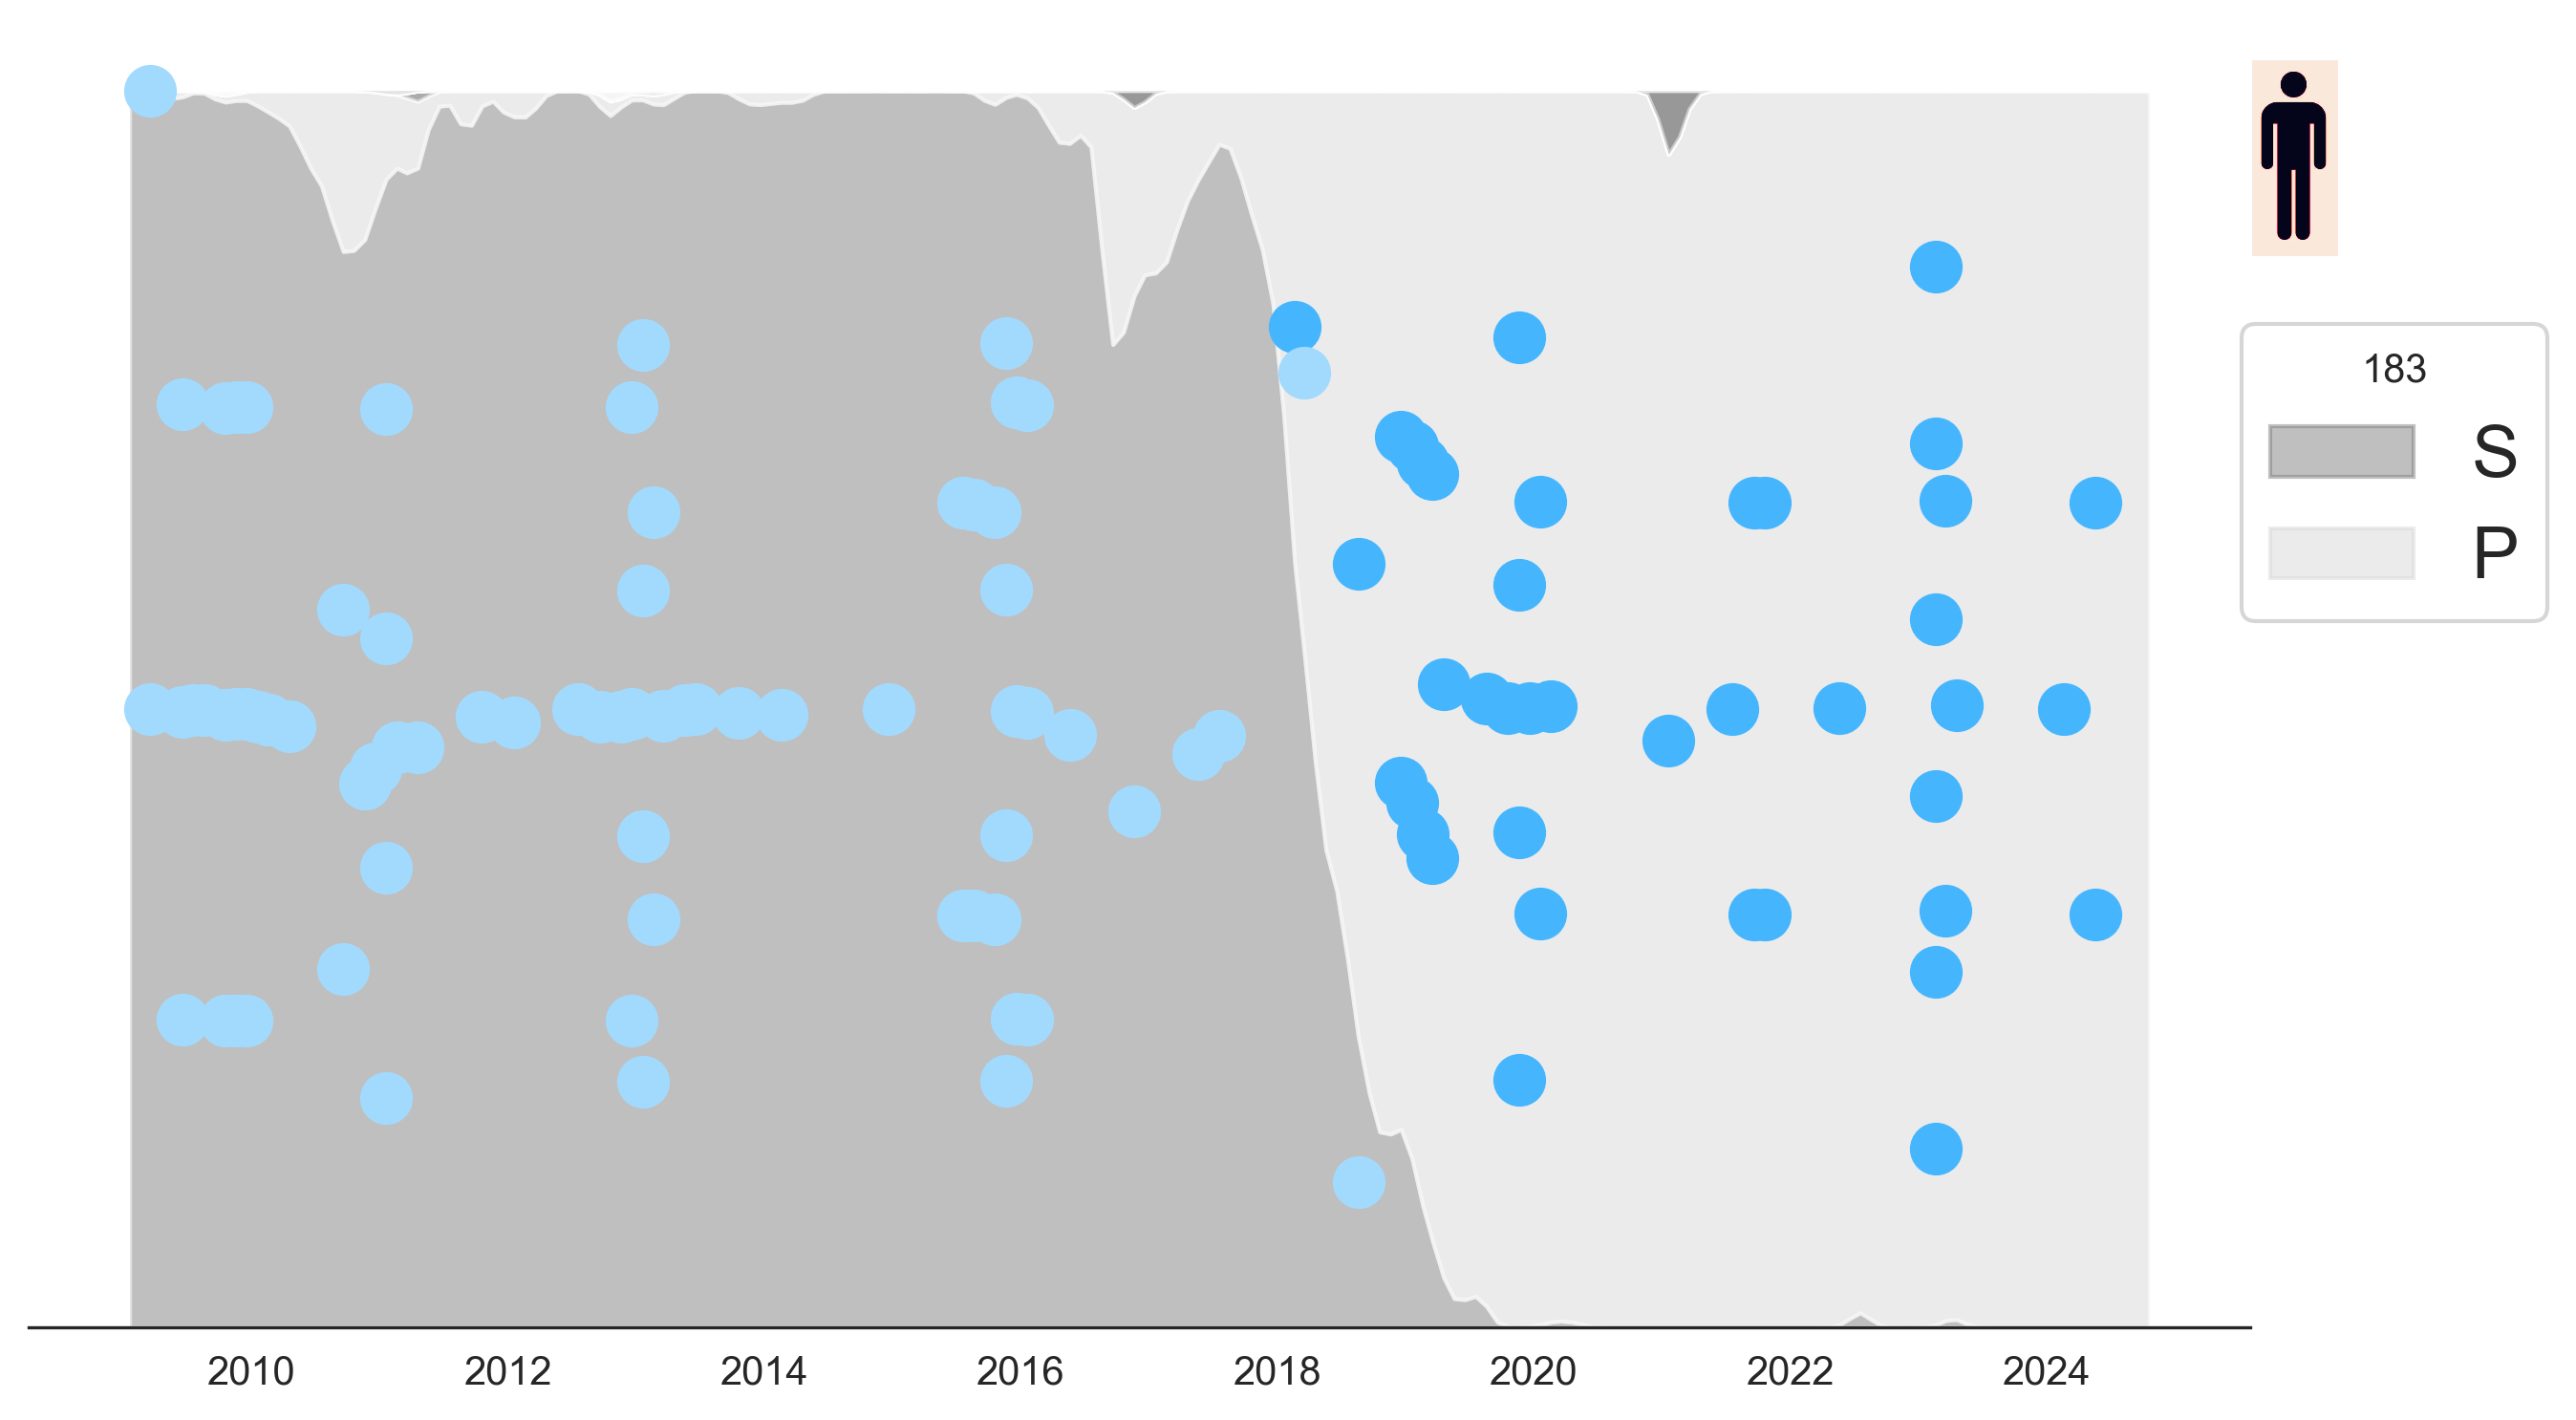

In [370]:
plot_site_aa_freqs('h1n1pdm', 'ha', 'HA1', 183, ['187V', '191I'])